## Préparation 1 & 2

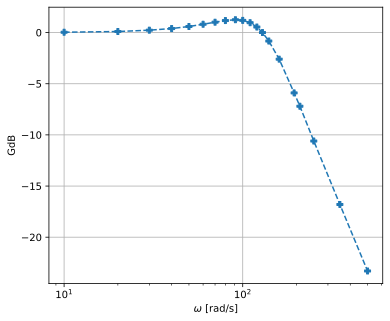

In [1]:
#| label: fig-gdb-process
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")

data = np.genfromtxt("data/BodeProcess.csv", delimiter=",")[1:,:]

w = data[:,0]
Gdb = data[:,1]
Phi = data[:,2]

plt.figure(figsize=(6,5))
plt.semilogx(w, Gdb, "P--")
plt.grid()
plt.xlabel(r"$\omega$ [rad/s]")
plt.ylabel(r"GdB")
plt.show()

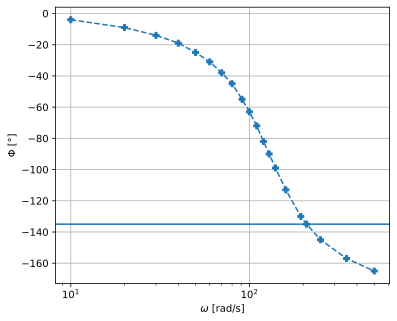

In [2]:
#| label: fig-phi-process
plt.figure(figsize=(6,5))
plt.semilogx(w, Phi, "P--")
plt.grid()
plt.xlabel(r"$\omega$ [rad/s]")
plt.ylabel(r"$\Phi$ [°]")
plt.axhline(y=-180+45)
plt.show()

## Préparation 3

Gdb(w45)=-5.73 dB
w45=192.65 rad/s
Gdb(wpi)=-23.91 dB
wpi=518.49 rad/s


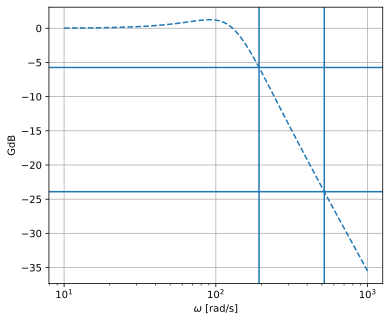

In [3]:
#| label: fig-Gdb-retard
from scipy import signal
import scipy

Kp = 1
w0 = 129 # [rad/s]
m  = 0.5
Te = 1e-3 # [s]
sys = signal.TransferFunction([Kp], [1/w0**2, 2*m/w0, 1])

w, Gdb, Phi = signal.bode(sys)
Phi -= (w*Te/2)*180/np.pi

# w45
def f(w):
    return signal.bode(sys, w)[2] - (w*Te/2)*180/np.pi +135
w45 = scipy.optimize.root(f, 100).x[0]
Gdb_w45 = signal.bode(sys, w45)[1][0]

# wi
def f(w):
    return signal.bode(sys, w)[2] - (w*Te/2)*180/np.pi +180
wpi = scipy.optimize.root(f, 100).x[0]
Gdb_wpi = signal.bode(sys, wpi)[1][0]

print(f"Gdb(w45)={Gdb_w45:.2f} dB")
print(f"w45={w45:.2f} rad/s")

print(f"Gdb(wpi)={Gdb_wpi:.2f} dB")
print(f"wpi={wpi:.2f} rad/s")
plt.figure(figsize=(6,5))
plt.semilogx(w, Gdb, "--")
plt.grid()
plt.xlabel(r"$\omega$ [rad/s]")
plt.ylabel(r"GdB")
plt.axvline(x=w45)
plt.axvline(x=wpi)
plt.axhline(y=Gdb_w45)
plt.axhline(y=Gdb_wpi)
plt.show()

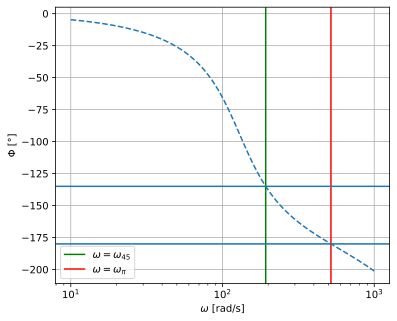

In [4]:
#| label: fig-Phi-retard
plt.figure(figsize=(6,5))
plt.semilogx(w, Phi, "--")
plt.grid()
plt.xlabel(r"$\omega$ [rad/s]")
plt.ylabel(r"$\Phi$ [°]")
plt.axvline(x=w45, color="g", label=r"$\omega=\omega_{45}$")
plt.axvline(x=wpi, color="r", label=r"$\omega=\omega_\pi$")

plt.axhline(y=-180+45)
plt.axhline(y=-180)

plt.legend()

plt.show()

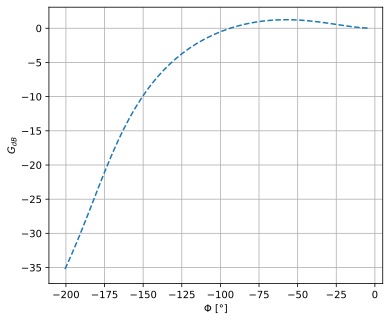

In [5]:
#| label: fig-black-retard
plt.figure(figsize=(6,5))
plt.plot(Phi, Gdb, "--")
plt.grid()
plt.xlabel(r"$\Phi$ [°]")
plt.ylabel(r"$G_{dB}$")
plt.show()

## Préparation 4

Ti=5.19 ms
Kp=0.71
 message: The solution converged.
 success: True
  status: 1
     fun: 1.4210854715202004e-13
       x: [ 7.752e-03]
  method: hybr
    nfev: 17
    fjac: [[-1.000e+00]]
       r: [-1.478e+04]
     qtf: [-9.318e-08]


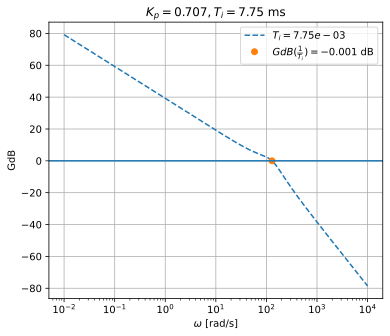

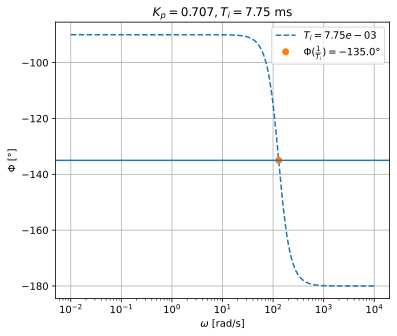

In [9]:
Ti = 1/w45
Kp = 0.707

print(f"Ti={Ti*1e3:.2f} ms")
print(f"Kp={Kp:.2f}")

w0 = 129 # [rad/s]
m  = 0.5
Te = 1e-3 # [s]
sys = signal.TransferFunction([1], [1/w0**2, 2*m/w0, 1])

def f(Ti):
    Ti = Ti[0]
    corr = signal.TransferFunction([Kp*Ti, Kp], [Ti, 0])
    # Ensure sys.num and sys.den are flattened arrays
    num = np.convolve(sys.num, corr.num)
    den = np.convolve(sys.den, corr.den)
    sys_BO = signal.TransferFunction(num, den)
    return signal.bode(sys_BO, 1/Ti)[2][0] + 135

root = scipy.optimize.root(f, 1.25e-2)
print(root)
Ti_opt = root.x[0]

def plot_Ti(Ti, plot="GdB"):
    corr = signal.TransferFunction([Kp*Ti, Kp], [Ti, 0])
    num = np.convolve(sys.num, corr.num)  # Polynomial multiplication
    den = np.convolve(sys.den, corr.den)
    sys_BO = signal.TransferFunction(num, den)
    w, Gdb, Phi = signal.bode(sys_BO, np.logspace(-2, 4, 1000))
    _, GdbTi, PhiTi = signal.bode(sys_BO, 1/Ti)
    if plot == "GdB":
        plt.semilogx(w, Gdb, "--", label=f"$T_i={Ti:.2e}$")
        GdbTi = GdbTi[0]
        plt.plot(1/Ti, GdbTi, "o", label=r"$GdB(\frac{1}{T_i})="+f"{GdbTi:.3f}$ dB")
    elif plot == "Phi":
        plt.semilogx(w, Phi, "--", label=f"$T_i={Ti:.2e}$")
        PhiTi = PhiTi[0]
        PhiTi = PhiTi % 360  # First normalize to [0, 360)
        if PhiTi > 0:
            PhiTi -= 360  # Convert to [-360, 0)
        plt.plot(1/Ti, PhiTi, "o", label=r"$\Phi(\frac{1}{T_i})="+f"{PhiTi:.1f}$°")


plt.figure(figsize=(6,5))
#Tis = np.linspace(1e-2, 1.5e-2, 5)
#for Ti in Tis:
#    plot_Ti(Ti)
plot_Ti(Ti_opt)
plt.grid()
plt.title(f"$K_p={Kp:.3f}, T_i={Ti_opt*1e3:.2f}$ ms")
plt.xlabel(r"$\omega$ [rad/s]")
plt.ylabel(r"GdB")
plt.axhline(y=0)
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
plt.title(f"$K_p={Kp:.3f}, T_i={Ti_opt*1e3:.2f}$ ms")
#for Ti in Tis:
#    plot_Ti(Ti, plot="Phi")
plot_Ti(Ti_opt, plot="Phi")
plt.grid()
plt.axhline(y=-135)
plt.xlabel(r"$\omega$ [rad/s]")
plt.ylabel(r"$\Phi$ [°]")
plt.legend()

plt.show()